### Loading All the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box

Using TensorFlow backend.


**Please Note**: I have not used HOG+SVM for this project. I have used an algorithm called YOLO. 
I am fulfilling all the technical rubric points, just by method other than HOG+SVM.

### Algorithm YOLO: You Only Look Once

YOLO reframes object detection as a single regression problem, straight from image pixels to bounding box coordinates
and class probabilities. A single convolutional network simultaneously predicts multiple bounding boxes and class probabilities for those boxes. YOLO trains on full images and directly optimizes detection performance.

In this project we will implement tiny-YOLO. Full details of the network, training and implementation are available in the paper - http://arxiv.org/abs/1506.02640

## Architecture

The model architecture consists of 9 convolutional layers, followed by 3 fully connected layers. Each convolutional layer is followed by a Leaky RELU activation function, with alpha of 0.1. The first 6 convolutional layers also have a 2x2 max pooling layers.

In this project, we will use Keras to construct the YOLO model.

In [2]:
keras.backend.set_image_dim_ordering('th')

In [3]:

model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [4]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## load weight from pretrained weights for yolo ##
The weight file can be downloaded from https://pjreddie.com/darknet/yolo/

In [9]:
load_weights(model,'./yolo-tiny.weights')

## Apply the model to a test images

In [10]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

In [11]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

### Interpolate the vector out from the neural network, generate the boxes

In [12]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)

### visualize the box on the original image

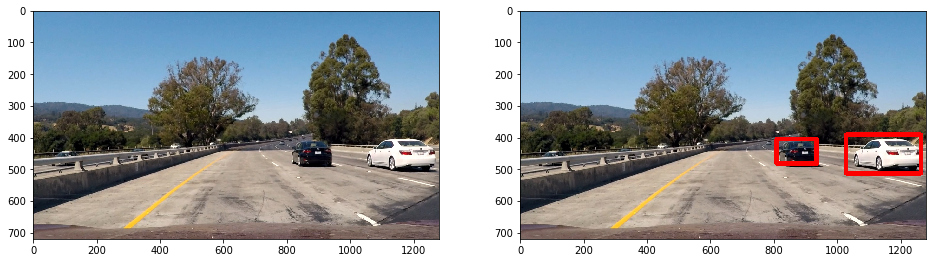

In [13]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

### More examples on test images

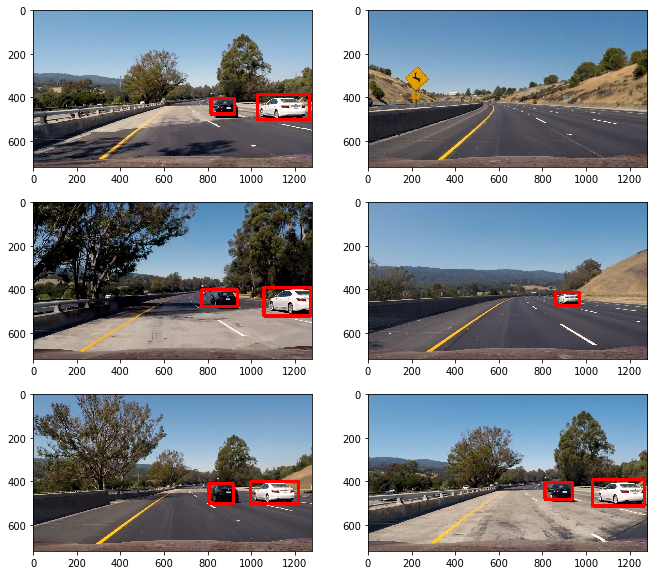

In [14]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
out = model.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.17)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))

## Applying to video

In [15]:
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
    return draw_box(boxes,image,[[500,1280],[300,650]])

In [16]:
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

In [17]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [44:04<00:02,  2.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 2h 35min 32s, sys: 1min 40s, total: 2h 37min 13s
Wall time: 44min 7s
